In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """
    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [7]:
client = pymongo.MongoClient()
db = client.metrics_causal_model_reranker

cb_td, cb_vd=  "CB_RE-RANKER_FEATURE_SEL_TD", "CB_RE-RANKER_FEATURE_SEL_VD"
# set to be the same for now
sc_td, sc_vd = "SC_RE-RANKER_FEATURE_SEL_TD", "SC_RE-RANKER_FEATURE_SEL_VD"

cb_td, cb_vd = db[cb_td], db[cb_vd]
sc_td, sc_vd = db[sc_td], db[sc_vd]

cb_td, cb_vd , sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'CB_RE-RANKER_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'CB_RE-RANKER_FEATURE_SEL_VD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'SC_RE-RANKER_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'SC_RE-RANKER_FEATURE_SEL_VD'))

# Query Top Features

In [8]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            #"stemmed":        "$parameters.stemmed",
            "num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

38 38 34 34


In [10]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,hs_feats
0,5d0257e5e116f5b521e0bc30,2019-06-13 15:04:21.766,3,"[CREL_, Prob-, CChainStats-]",0.746068,0.786176,0.709854,0.0,CChainStats-|CREL_|Prob-
1,5d025ac1e116f5b521e0bc38,2019-06-13 15:16:33.911,4,"[CREL_, Prob-, CChainStats-, CREL_Pair-]",0.745782,0.785541,0.709854,0.0,CChainStats-|CREL_|CREL_Pair-|Prob-
2,5d025f47e116f5b521e0bc46,2019-06-13 15:35:51.096,4,"[CREL_, Prob-, CChainStats-, Diff_]",0.745782,0.785541,0.709854,0.0,CChainStats-|CREL_|Diff_|Prob-


In [11]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2019-06-13T14:22:46.187000000'),
 numpy.datetime64('2019-06-13T15:35:51.096000000'))

In [30]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision".split(",")
sc_cols = "feats,count,micro_f1_score,micro_recall,micro_precision,num_feats".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, cols=cols):
    df_top_individual_feats = df[(df["count"] == 1)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, False)

### Performance of Each Feature In Isolation

In [34]:
# pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])

In [36]:
import numpy as np
stemmed = True
a, b = get_top_individual_feats(cb_vd_df), get_top_individual_feats(sc_vd_df, sc_cols)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats".split(",")]

merged["num_feats_SC"] = merged["num_feats"]
del merged["num_feats"]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC
0,1,CREL_,0.742998,0.716423,0.771619,CREL_,0.806408,0.753234,0.867660,549.4
1,2,num_crels,0.741540,0.727737,0.755876,Tally-,0.806185,0.753741,0.866472,24.0
2,3,Tally-,0.741540,0.727737,0.755876,num_crels,0.806185,0.753741,0.866472,33.0
3,4,Above-,0.732855,0.670803,0.807557,Above-,0.803667,0.744864,0.872549,21.0
4,5,CREL_Pair-,0.718858,0.680292,0.762061,Prob-,0.796480,0.734466,0.869931,12.0
5,6,Propn_,0.633727,0.538321,0.770235,CChainStats-,0.748804,0.655085,0.873816,27.0
6,7,CChainStats-,0.625053,0.535401,0.750768,Propn_,0.663651,0.539437,0.862181,3.8
7,8,Diff_,0.559387,0.426277,0.813370,Diff_,0.645409,0.510779,0.876414,4.0
8,9,Prob-,0.532302,0.389416,0.840820,CChain-,0.638298,0.498352,0.887534,120.6
9,10,CChain-,0.479339,0.349270,0.763767,Inv-,0.006552,0.003297,0.520000,4.0


In [37]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", #"num_feats_CB",
                "feats_SC", "micro_f1_score_SC", "num_feats_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC,num_feats_SC
0,1,CREL_,0.743,CREL_,0.806,549.4
1,2,num_crels,0.742,Tally-,0.806,24.0
2,3,Tally-,0.742,num_crels,0.806,33.0
3,4,Above-,0.733,Above-,0.804,21.0
4,5,CREL_Pair-,0.719,Prob-,0.796,12.0
5,6,Propn_,0.634,CChainStats-,0.749,27.0
6,7,CChainStats-,0.625,Propn_,0.664,3.8
7,8,Diff_,0.559,Diff_,0.645,4.0
8,9,Prob-,0.532,CChain-,0.638,120.6
9,10,CChain-,0.479,Inv-,0.007,4.0


## Generate Rows for LaTex Table

In [38]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

In [39]:
for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & CREL & 0.743 & & CREL & 0.806\\
2 & num crels & 0.742 & & Tally- & 0.806\\
3 & Tally- & 0.742 & & num crels & 0.806\\
4 & Above- & 0.733 & & Above- & 0.804\\
5 & CREL Pair- & 0.719 & & Prob- & 0.796\\
6 & Propn & 0.634 & & CChainStats- & 0.749\\
7 & CChainStats- & 0.625 & & Propn & 0.664\\
8 & Diff & 0.559 & & Diff & 0.645\\
9 & Prob- & 0.532 & & CChain- & 0.638\\
10 & CChain- & 0.479 & & Inv- & 0.007\\


## Performance By Feature Set Size

In [40]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.742998,0.591600,0.806408,0.672164
1,2,0.743783,0.742666,0.806627,0.806232
2,3,0.746068,0.742965,0.806684,0.806138
3,4,0.745782,0.744267,0.806684,0.806378


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [50]:
# cols_filter = "count,new_feat,micro_f1_score,num_feats".split(",")
cols_filter = "count,new_feat,micro_f1_score".split(",")

def get_f1_by_feat_count(df):
#     df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
##df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,CREL_,0.742998,CREL_,0.806408
1,2,Prob-,0.743783,CChain-,0.806627
2,3,CChainStats-,0.746068,Prob-,0.806684
3,4,CREL_Pair-,0.745782,Diff_,0.806684


In [51]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
# df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
# df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,CREL_,0.7430,CREL_,0.8064
1,2,Prob-,0.7438,CChain-,0.8066
2,3,CChainStats-,0.7461,Prob-,0.8067
3,4,CREL_Pair-,0.7458,Diff_,0.8067


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [52]:
def get_max_f1_by_feat_count(df):
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(1, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [54]:
df_cb = get_max_f1_by_feat_count(cb_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,1,[CREL_],0.742998,0.771619,0.716423,[CREL_],0.806408,0.867660,0.753234
1,2,"[CREL_, Prob-]",0.743783,0.788312,0.704015,"[CREL_, CChain-]",0.806627,0.868167,0.753234
2,3,"[CREL_, Prob-, CChainStats-]",0.746068,0.786176,0.709854,"[CREL_, CChain-, Prob-]",0.806684,0.868637,0.752980
3,4,"[CREL_, Prob-, CChainStats-, CREL_Pair-]",0.745782,0.785541,0.709854,"[CREL_, CChain-, Prob-, Diff_]",0.806684,0.868637,0.752980


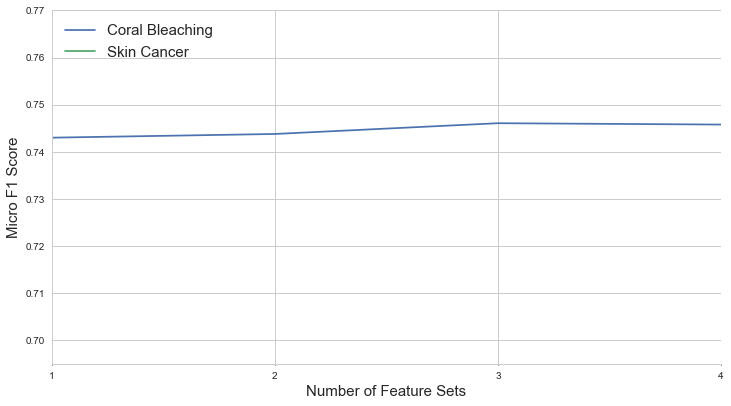

In [57]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 4])
ax1.set_ylim([0.695, 0.77])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/re-ranker_f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [58]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & CREL & 0.7430 & & CREL & 0.8064\\
2 & Prob- & 0.7438 & & CChain- & 0.8066\\
3 & CChainStats- & 0.7461 & & Prob- & 0.8067\\
4 & CREL Pair- & 0.7458 & & Diff & 0.8067\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [60]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"